# Makine Öğrenimi ile Fiyat Konut Tahmini: Outlier Temizleme

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [5]:
df = pd.read_excel(r"C:\Users\Monster\Desktop\konut-fiyat-tahmin-projesi\Veri Seti\istanbul_konut2.xlsx")

In [6]:
# Eksik değerlerin toplamını ve oranını göster
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100

# Eksik değer tablosu oluştur
missing_data = pd.DataFrame({'Eksik Değerler': missing_values, 'Eksik Oranı (%)': missing_percent})
print(missing_data)

               Eksik Değerler  Eksik Oranı (%)
Fiyat                       0         0.000000
İlce                        0         0.000000
Mahalle                     0         0.000000
Metre Kare                  0         0.000000
Oda Sayısı                  2         0.006988
Yaş                        24         0.083852
Bulunduğu Kat             936         3.270212


In [7]:
# 'Yaş' sütunundaki eksik değerleri medyan ile doldur
df['Yaş'] = df['Yaş'].fillna(df['Yaş'].median())
# 'Bulunduğu Kat' sütunundaki eksik değerleri mod ile doldur
df['Bulunduğu Kat'] = df['Bulunduğu Kat'].fillna(df['Bulunduğu Kat'].mode()[0])
# Oda Sayısı sütunundaki eksik değerleri mod (en sık görülen değer) ile doldur
most_frequent_value = df['Oda Sayısı'].mode()[0]
df['Oda Sayısı'] = df['Oda Sayısı'].fillna(most_frequent_value)
print(df.isnull().sum())

Fiyat            0
İlce             0
Mahalle          0
Metre Kare       0
Oda Sayısı       0
Yaş              0
Bulunduğu Kat    0
dtype: int64


In [8]:
df

,Fiyat,İlce,Mahalle,Metre Kare,Oda Sayısı,Yaş,Bulunduğu Kat
0,5000000,Adalar,Burgazada Mah,55,2.0,24.0,0.0
1,7500000,Adalar,Nizam Mah,65,2.0,31.0,0.0
2,4750000,Adalar,Nizam Mah,60,2.0,34.0,0.0
3,7000000,Adalar,MadeMah,75,2.0,35.0,0.0
4,4200000,Adalar,Nizam Mah,51,2.0,38.0,0.0
...,...,...,...,...,...,...,...
28617,4150000,Zeytinburnu,VeliefendMah.,150,6.0,29.0,1.0
28618,4500000,Zeytinburnu,VeliefendMah.,170,6.0,30.0,1.0
28619,17000000,Zeytinburnu,Gökalp Mah.,350,12.0,16.0,0.0
28620,19000000,Zeytinburnu,Beştelsiz Mah.,500,12.0,28.0,0.0


,Fiyat,İlce,Mahalle,Metre Kare,Oda Sayısı,Yaş,Bulunduğu Kat
0,5000000,Adalar,Burgazada Mah,55,2.0,24.0,0.0
1,7500000,Adalar,Nizam Mah,65,2.0,31.0,0.0
2,4750000,Adalar,Nizam Mah,60,2.0,34.0,0.0
3,7000000,Adalar,MadeMah,75,2.0,35.0,0.0
4,4200000,Adalar,Nizam Mah,51,2.0,38.0,0.0
...,...,...,...,...,...,...,...
28617,4150000,Zeytinburnu,VeliefendMah.,150,6.0,29.0,1.0
28618,4500000,Zeytinburnu,VeliefendMah.,170,6.0,30.0,1.0
28619,17000000,Zeytinburnu,Gökalp Mah.,350,12.0,16.0,0.0
28620,19000000,Zeytinburnu,Beştelsiz Mah.,500,12.0,28.0,0.0


# Target Encoding (Mean Encoding)

Her bir ilçe/mahalle, o ilçe/mahalledeki ortalama konut fiyatı ile değiştirilir

In [9]:
# Target Encoding uygulama
def target_encode(df, target_col):
    # İlce için ortalama fiyatları hesapla
    ilce_means = df.groupby('İlce')[target_col].mean()
    df['Ilce_encoded'] = df['İlce'].map(ilce_means)

    # Mahalle için ortalama fiyatları hesapla
    mahalle_means = df.groupby('Mahalle')[target_col].mean()
    df['Mahalle_encoded'] = df['Mahalle'].map(mahalle_means)

    return df

# Target Encoding'i uygula
df_encoded = target_encode(df.copy(), 'Fiyat')

# Özellikler (X) ve hedef değişkeni (y) belirleyelim
X = df_encoded[['Metre Kare', 'Oda Sayısı', 'Yaş', 'Bulunduğu Kat', 'Ilce_encoded', 'Mahalle_encoded']]
y = df_encoded['Fiyat']

# Veriyi eğitim ve test olarak ayır
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest modelini oluştur ve eğit
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Test verisi üzerinde tahmin yap
y_pred = model.predict(X_test)

# R² skorunu hesapla
r2 = r2_score(y_test, y_pred)

# Sonucu yazdır
print("Target Encoding uygulanmış veri seti ile R² değeri (Random Forest):")
print("R² Score:", r2)

Target Encoding uygulanmış veri seti ile R² değeri (Random Forest):
R² Score: 0.8296936501480221


#                 Outlier Değerleri Temizleme

# 1- Z-Score (Standart Sapma Yöntemi)

Verinin ortalaması ve standart sapması hesaplanır. Z-skoru gözlem değerinden ortalama çıkarılıp standart sapmaya bölünmesi ile bulunur. Genellikle Z-skoru > 3 veya Z-skoru < -3 olan değerler aykırı olarak kabul edilir ve çıkarılır.

In [10]:
# Özellikler ve hedef değişkeni belirleme
X = df_encoded[['Metre Kare', 'Oda Sayısı', 'Yaş', 'Bulunduğu Kat', 'Ilce_encoded', 'Mahalle_encoded']]
y = df_encoded['Fiyat']

# Z-Score yöntemiyle aykırı değerleri temizleme
z_scores = np.abs((X - X.mean()) / X.std())  # Z-Skoru hesapla
threshold = 3  # Z-Skoru eşik değeri
mask = (z_scores < threshold).all(axis=1)  # Aykırı olmayanları seç
X_clean = X[mask]
y_clean = y[mask]

# Veriyi eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)

# Modeli eğitme
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Modelin performansını değerlendirme
y_pred = rf_model.predict(X_test)
r2 = r2_score(y_test, y_pred)

print(f'R^2 Skoru: {r2:.4f}')
print(f'Veri sayısı: {len(X_clean)}')

R^2 Skoru: 0.8391
Veri sayısı: 27089


<Figure size 1500x600 with 0 Axes>

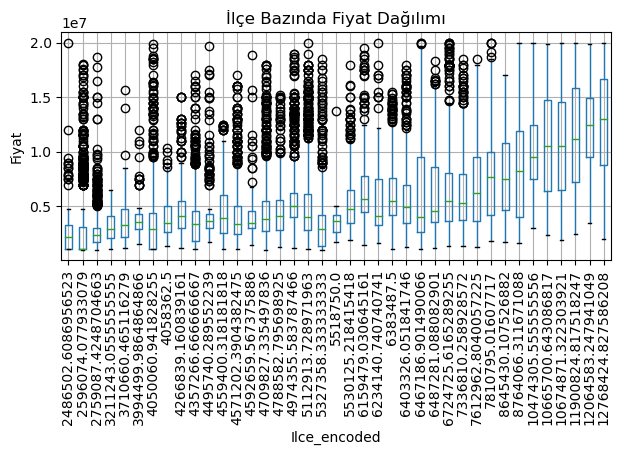

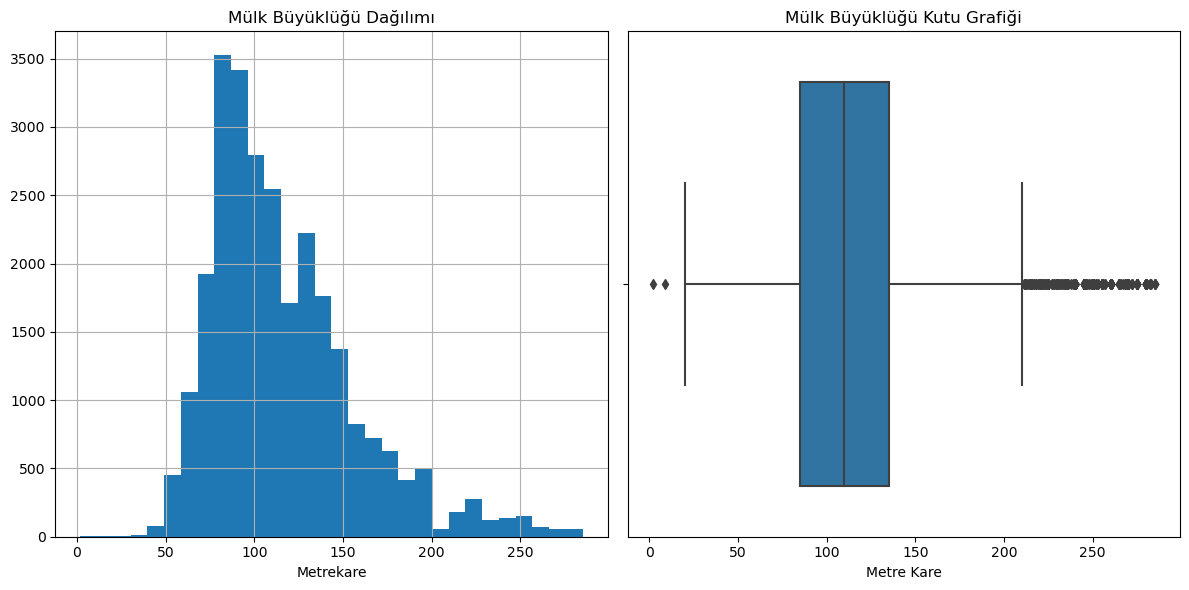

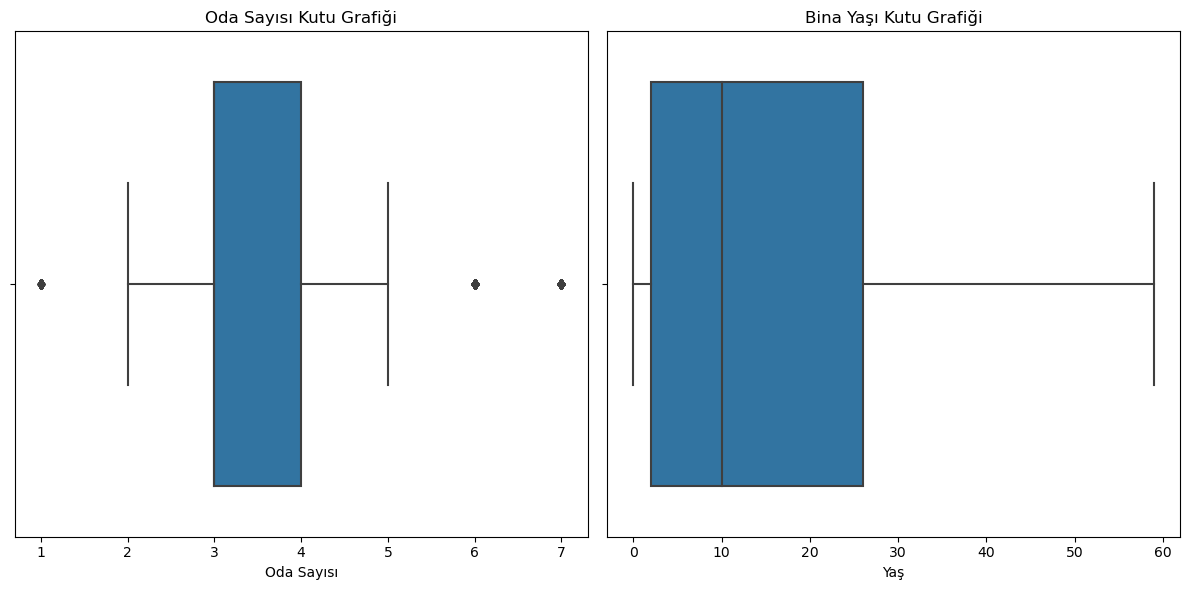

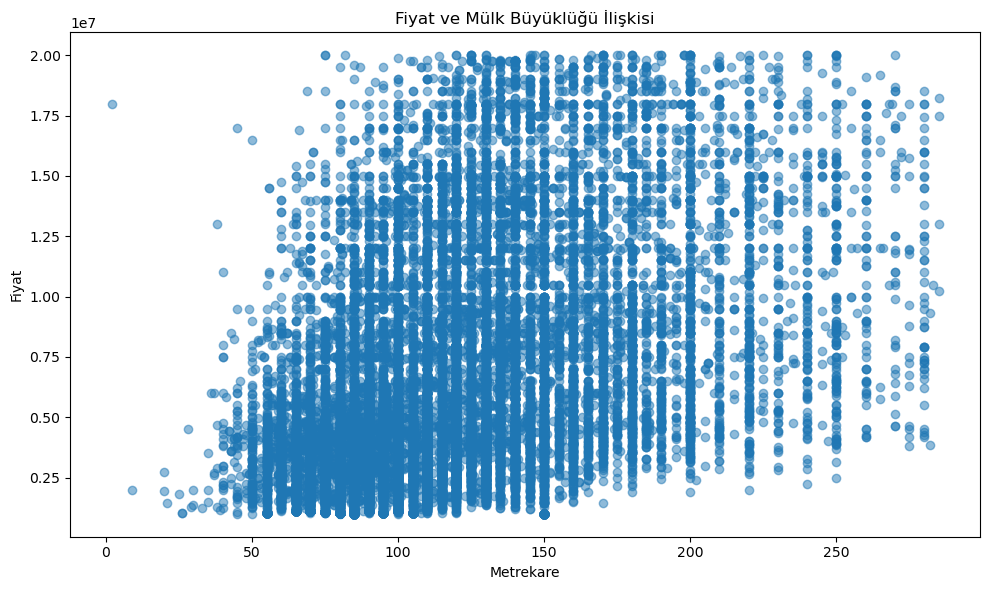

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df_clean = pd.concat([X_clean, y_clean], axis=1)
# DataFrame yüklü olduğunu varsayıyoruz: 'df'
def veri_kesif_analizi(df_clean):
    
    # İlçe Bazında Fiyat Dağılımı
    plt.figure(figsize=(15, 6))
    df_clean.boxplot(column='Fiyat', by='Ilce_encoded', rot=90)
    plt.title('İlçe Bazında Fiyat Dağılımı')
    plt.suptitle('')  # Otomatik başlığı kaldırır
    plt.ylabel('Fiyat')
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(12, 6))
    
    # 1. Grafik: Mülk Büyüklüğü Dağılımı
    plt.subplot(1, 2, 1)
    df_clean['Metre Kare'].hist(bins=30)
    plt.title('Mülk Büyüklüğü Dağılımı')
    plt.xlabel('Metrekare')
    
    # 2. Grafik: Mülk Büyüklüğü Kutu Grafiği
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df_clean['Metre Kare'])
    plt.title('Mülk Büyüklüğü Kutu Grafiği')
    
    plt.tight_layout()
    plt.show()
    
    # Yeni bir figure açarak ikinci grup grafikleri yerleştiriyoruz
    plt.figure(figsize=(12, 6))
    
    # 3. Grafik: Oda Sayısı Kutu Grafiği
    plt.subplot(1, 2, 1)
    sns.boxplot(x=df_clean['Oda Sayısı'])
    plt.title('Oda Sayısı Kutu Grafiği')
    
    # 4. Grafik: Yaş Kutu Grafiği
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df_clean['Yaş'])
    plt.title('Bina Yaşı Kutu Grafiği')
    
    plt.tight_layout()
    plt.show()
    
    # Fiyat ve Metrekare İlişkisi
    plt.figure(figsize=(10, 6))
    plt.scatter(df_clean['Metre Kare'], df_clean['Fiyat'], alpha=0.5)
    plt.title('Fiyat ve Mülk Büyüklüğü İlişkisi')
    plt.xlabel('Metrekare')
    plt.ylabel('Fiyat')
    plt.tight_layout()
    plt.show()
    

# Fonksiyonu Çağır
veri_kesif_analizi(df_clean)

# 2- IQR (Interquartile Range – Çeyrekler Aralığı)

IQR = Q3 - Q1 (3. çeyrek ile 1. çeyrek arasındaki fark) hesaplanır.

In [12]:
# Özellikler ve hedef değişkeni belirleme
X = df_encoded[['Metre Kare', 'Oda Sayısı', 'Yaş', 'Bulunduğu Kat', 'Ilce_encoded', 'Mahalle_encoded']]
y = df_encoded['Fiyat']

# IQR yöntemiyle aykırı değerleri temizleme
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 2 * IQR
upper_bound = Q3 + 2 * IQR
mask = ~((X < lower_bound) | (X > upper_bound)).any(axis=1)
X_clean = X[mask]
y_clean = y[mask]

# Veriyi eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)

# Modeli eğitme
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Modelin performansını değerlendirme
y_pred = rf_model.predict(X_test)
r2 = r2_score(y_test, y_pred)

print(f'R^2 Skoru: {r2:.4f}')
print(f'Veri sayısı: {len(X_clean)}')

R^2 Skoru: 0.8501
Veri sayısı: 26630


<Figure size 1500x600 with 0 Axes>

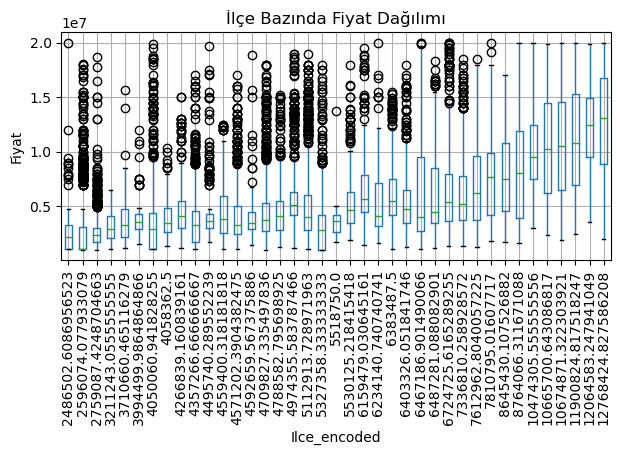

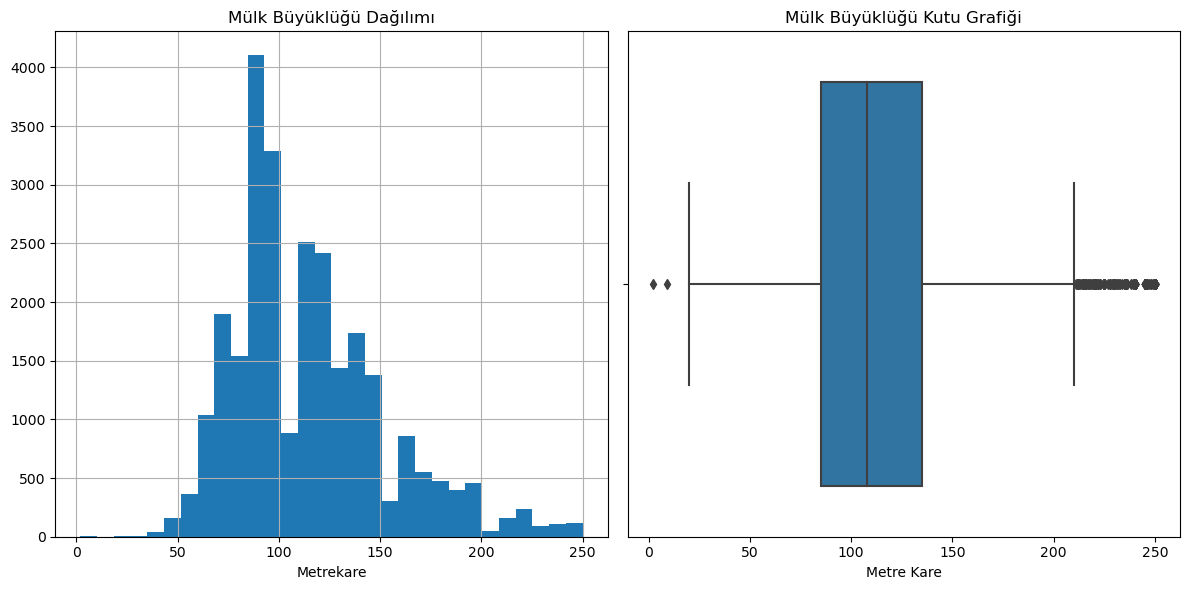

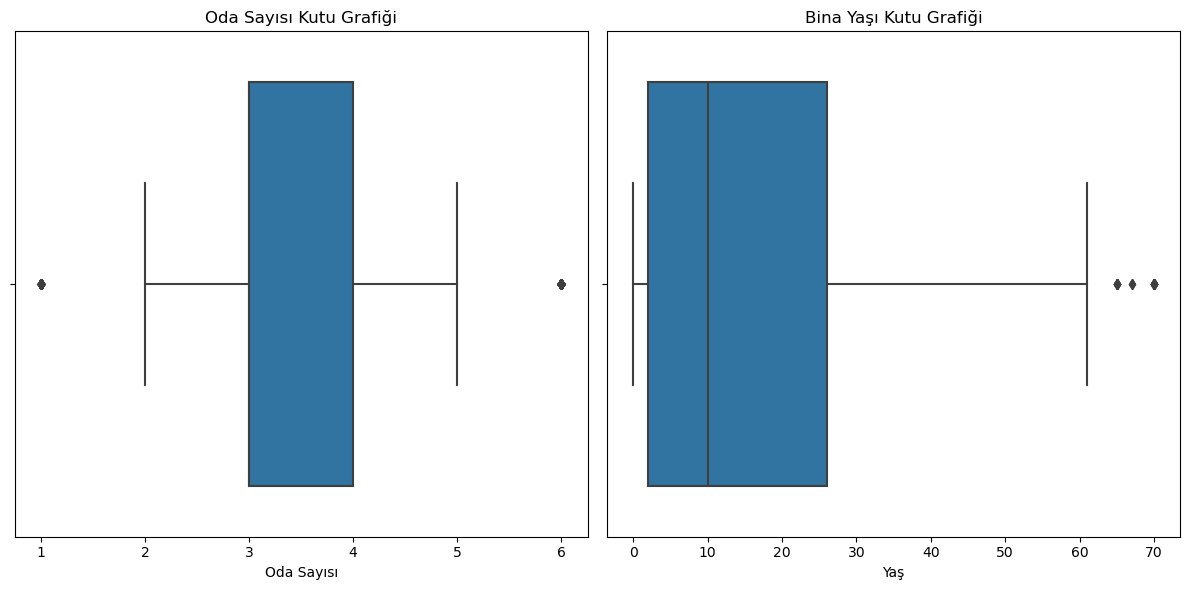

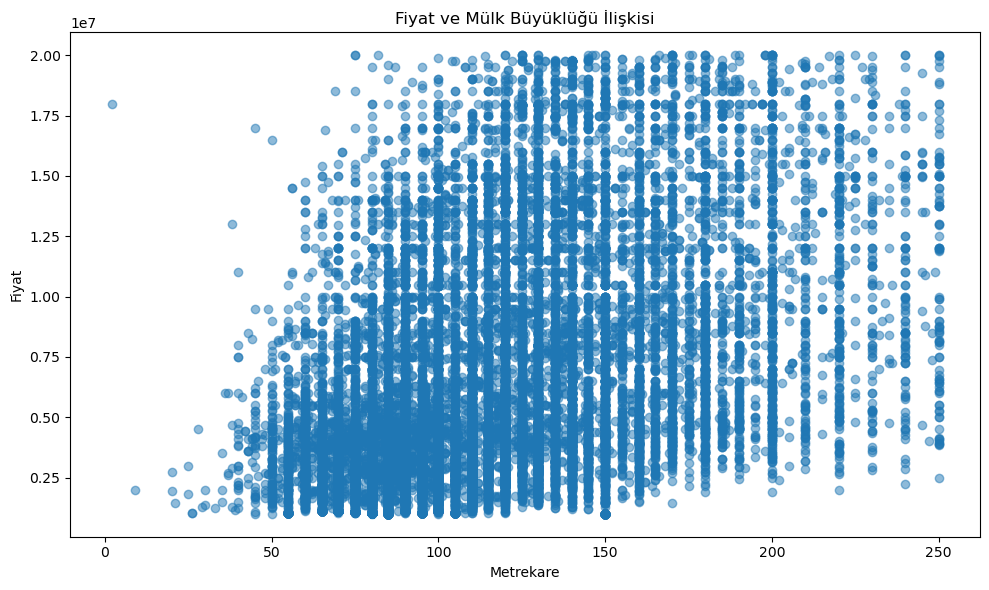

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df_clean = pd.concat([X_clean, y_clean], axis=1)
# DataFrame yüklü olduğunu varsayıyoruz: 'df'
def veri_kesif_analizi(df_clean):
    
    # İlçe Bazında Fiyat Dağılımı
    plt.figure(figsize=(15, 6))
    df_clean.boxplot(column='Fiyat', by='Ilce_encoded', rot=90)
    plt.title('İlçe Bazında Fiyat Dağılımı')
    plt.suptitle('')  # Otomatik başlığı kaldırır
    plt.ylabel('Fiyat')
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(12, 6))
    
    # 1. Grafik: Mülk Büyüklüğü Dağılımı
    plt.subplot(1, 2, 1)
    df_clean['Metre Kare'].hist(bins=30)
    plt.title('Mülk Büyüklüğü Dağılımı')
    plt.xlabel('Metrekare')
    
    # 2. Grafik: Mülk Büyüklüğü Kutu Grafiği
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df_clean['Metre Kare'])
    plt.title('Mülk Büyüklüğü Kutu Grafiği')
    
    plt.tight_layout()
    plt.show()
    
    # Yeni bir figure açarak ikinci grup grafikleri yerleştiriyoruz
    plt.figure(figsize=(12, 6))
    
    # 3. Grafik: Oda Sayısı Kutu Grafiği
    plt.subplot(1, 2, 1)
    sns.boxplot(x=df_clean['Oda Sayısı'])
    plt.title('Oda Sayısı Kutu Grafiği')
    
    # 4. Grafik: Yaş Kutu Grafiği
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df_clean['Yaş'])
    plt.title('Bina Yaşı Kutu Grafiği')
    
    plt.tight_layout()
    plt.show()
    
    # Fiyat ve Metrekare İlişkisi
    plt.figure(figsize=(10, 6))
    plt.scatter(df_clean['Metre Kare'], df_clean['Fiyat'], alpha=0.5)
    plt.title('Fiyat ve Mülk Büyüklüğü İlişkisi')
    plt.xlabel('Metrekare')
    plt.ylabel('Fiyat')
    plt.tight_layout()
    plt.show()
    

# Fonksiyonu Çağır
veri_kesif_analizi(df_clean)

# 3-Winsorization (Değerleri Kırpma)

Aykırı değerleri tamamen silmek yerine, belirlenen üst ve alt sınır değerlerine yuvarlanarak değiştirilir.

In [13]:
from scipy.stats.mstats import winsorize


# Özellikler ve hedef değişkeni belirleme
X = df_encoded[['Metre Kare', 'Oda Sayısı', 'Yaş', 'Bulunduğu Kat', 'Ilce_encoded', 'Mahalle_encoded']]
y = df_encoded['Fiyat']

# Winsorization yöntemiyle aykırı değerleri kırpma
limits = (0.05, 0.05)  # Alt ve üst %5'lik dilimleri kırpma
X_winsorized = X.apply(lambda col: winsorize(col, limits=limits))

# Veriyi eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X_winsorized, y, test_size=0.2, random_state=42)

# Modeli eğitme
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Modelin performansını değerlendirme
y_pred = rf_model.predict(X_test)
r2 = r2_score(y_test, y_pred)

print(f'R^2 Skoru: {r2:.4f}')
print(f'Veri sayısı: {len(X_clean)}')


R^2 Skoru: 0.8258
Veri sayısı: 26630


<Figure size 1500x600 with 0 Axes>

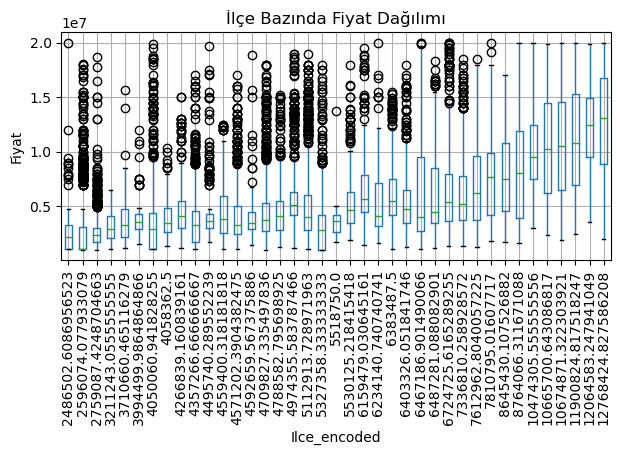

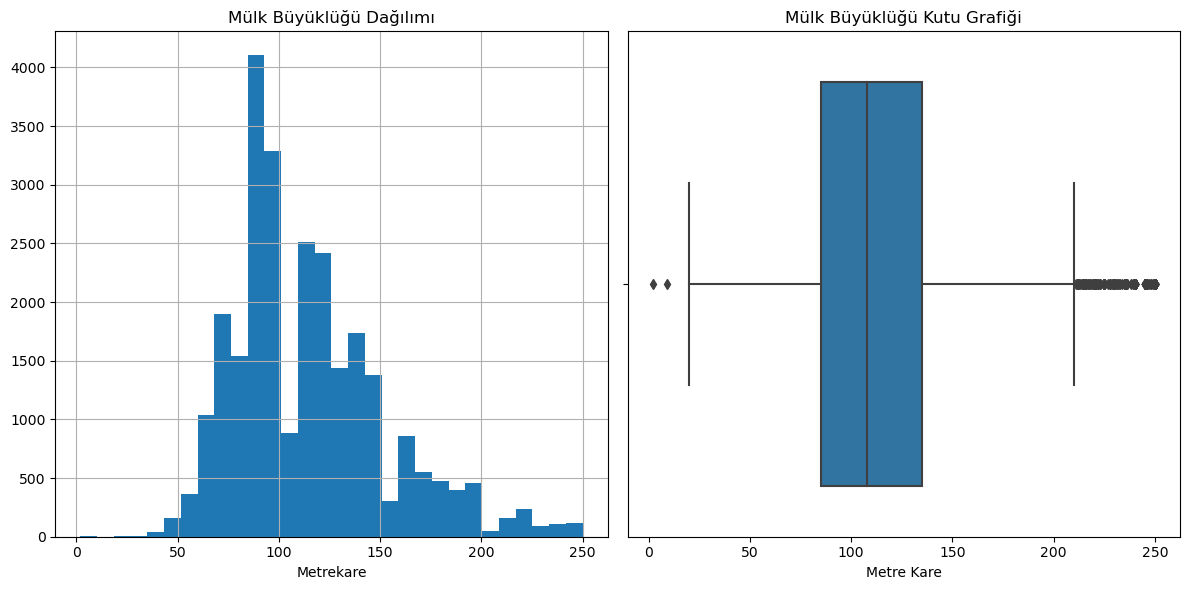

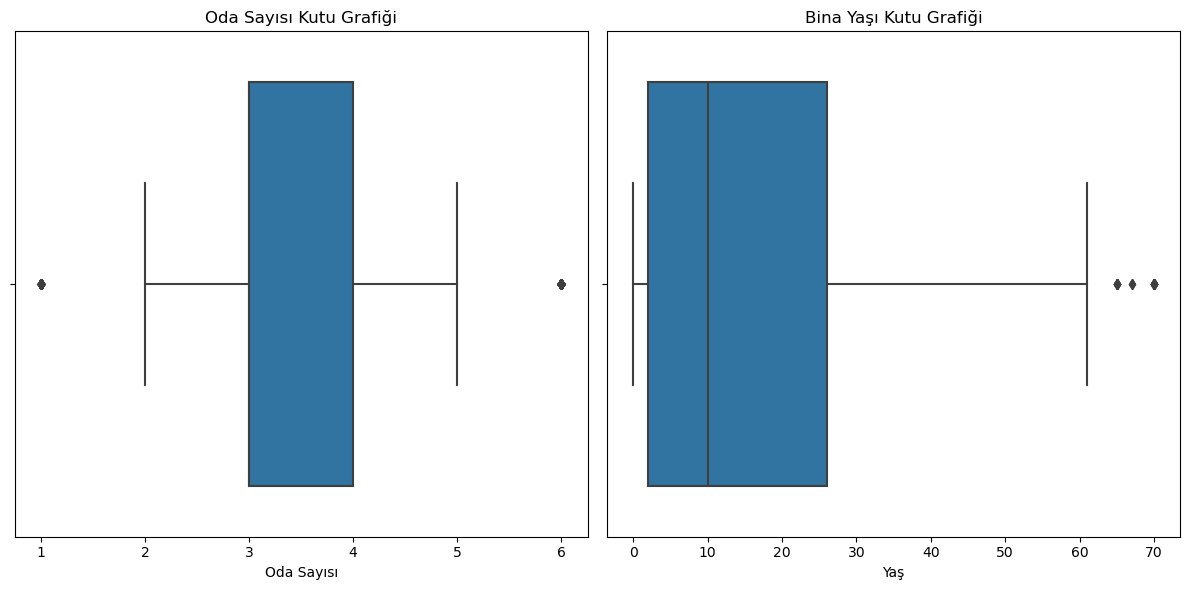

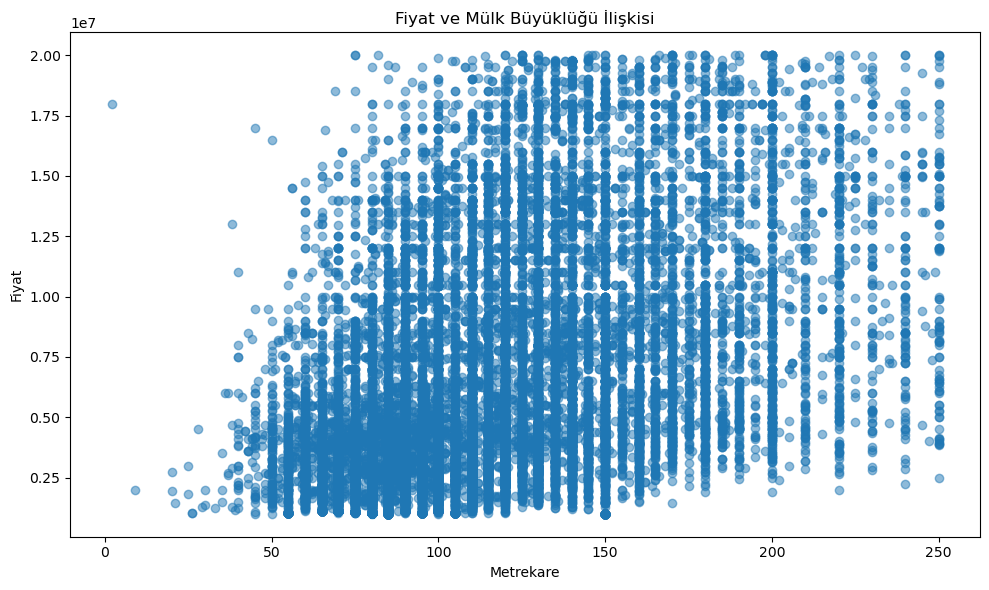

In [14]:
df_clean = pd.concat([X_clean, y_clean], axis=1)
# DataFrame yüklü olduğunu varsayıyoruz: 'df'
def veri_kesif_analizi(df_clean):
    
    # İlçe Bazında Fiyat Dağılımı
    plt.figure(figsize=(15, 6))
    df_clean.boxplot(column='Fiyat', by='Ilce_encoded', rot=90)
    plt.title('İlçe Bazında Fiyat Dağılımı')
    plt.suptitle('')  # Otomatik başlığı kaldırır
    plt.ylabel('Fiyat')
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(12, 6))
    
    # 1. Grafik: Mülk Büyüklüğü Dağılımı
    plt.subplot(1, 2, 1)
    df_clean['Metre Kare'].hist(bins=30)
    plt.title('Mülk Büyüklüğü Dağılımı')
    plt.xlabel('Metrekare')
    
    # 2. Grafik: Mülk Büyüklüğü Kutu Grafiği
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df_clean['Metre Kare'])
    plt.title('Mülk Büyüklüğü Kutu Grafiği')
    
    plt.tight_layout()
    plt.show()
    
    # Yeni bir figure açarak ikinci grup grafikleri yerleştiriyoruz
    plt.figure(figsize=(12, 6))
    
    # 3. Grafik: Oda Sayısı Kutu Grafiği
    plt.subplot(1, 2, 1)
    sns.boxplot(x=df_clean['Oda Sayısı'])
    plt.title('Oda Sayısı Kutu Grafiği')
    
    # 4. Grafik: Yaş Kutu Grafiği
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df_clean['Yaş'])
    plt.title('Bina Yaşı Kutu Grafiği')
    
    plt.tight_layout()
    plt.show()
    
    # Fiyat ve Metrekare İlişkisi
    plt.figure(figsize=(10, 6))
    plt.scatter(df_clean['Metre Kare'], df_clean['Fiyat'], alpha=0.5)
    plt.title('Fiyat ve Mülk Büyüklüğü İlişkisi')
    plt.xlabel('Metrekare')
    plt.ylabel('Fiyat')
    plt.tight_layout()
    plt.show()
    

# Fonksiyonu Çağır
veri_kesif_analizi(df_clean)

# 4- Isolation Forest

Ağaç tabanlı bir algoritmadır. Aykırı değerler, veri bölümlenirken daha erken ayrılan noktalar olarak belirlenir.

In [15]:
from sklearn.ensemble import RandomForestRegressor, IsolationForest

# Özellikler ve hedef değişkeni belirleme
X = df_encoded[['Metre Kare', 'Oda Sayısı', 'Yaş', 'Bulunduğu Kat', 'Ilce_encoded', 'Mahalle_encoded']]
y = df_encoded['Fiyat']

# Isolation Forest yöntemiyle aykırı değerleri tespit etme
iso_forest = IsolationForest(contamination=0.05, random_state=42)
outlier_pred = iso_forest.fit_predict(X)
mask = outlier_pred != -1  # Aykırı olmayanları seç
X_clean = X[mask]
y_clean = y[mask]

# Veriyi eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)

# Modeli eğitme
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Modelin performansını değerlendirme
y_pred = rf_model.predict(X_test)
r2 = r2_score(y_test, y_pred)

print(f'R^2 Skoru: {r2:.4f}')
print(f'Veri sayısı: {len(X_clean)}')

R^2 Skoru: 0.8279
Veri sayısı: 27190


<Figure size 1500x600 with 0 Axes>

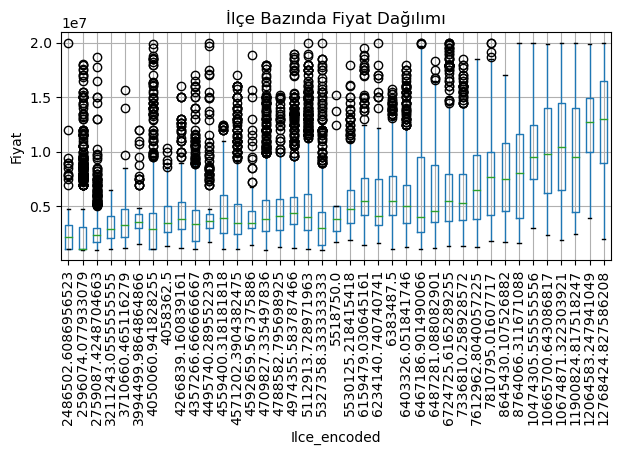

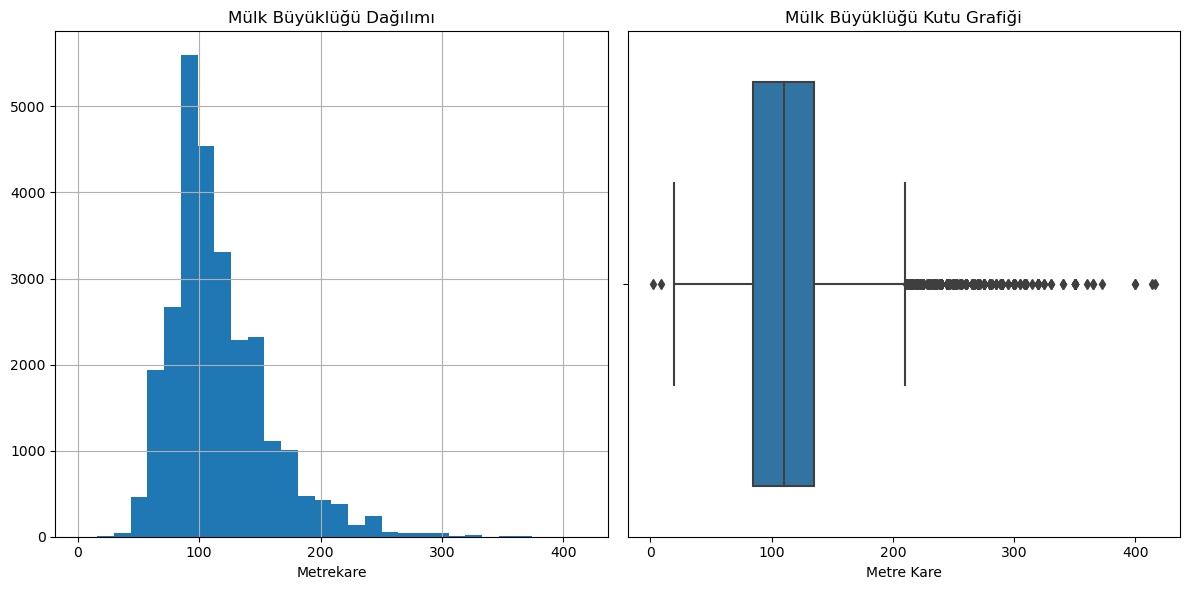

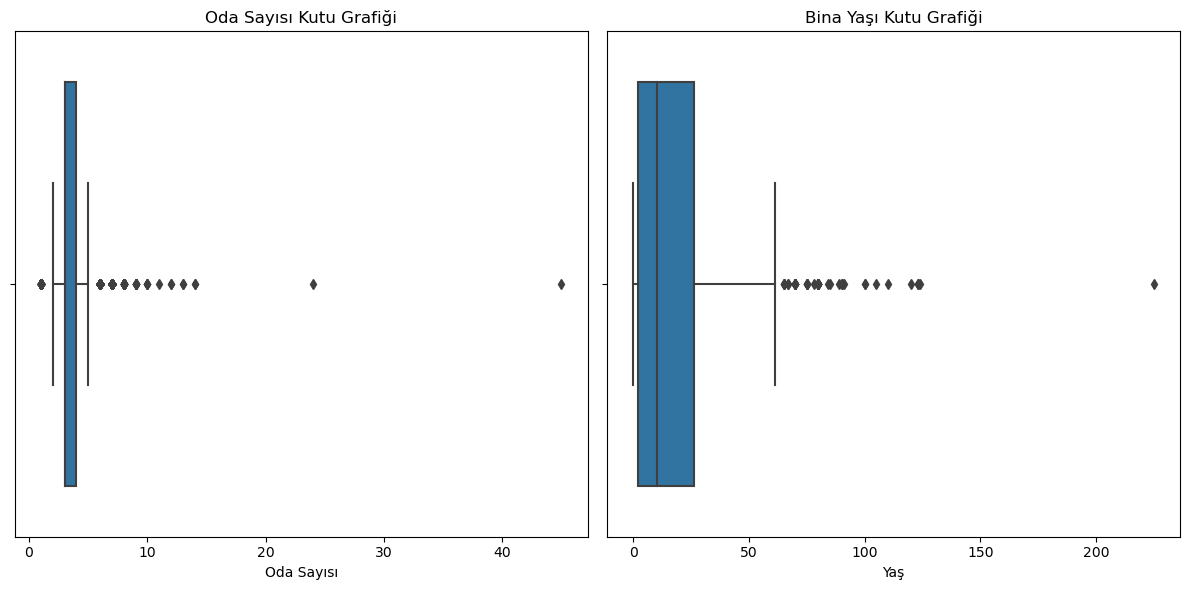

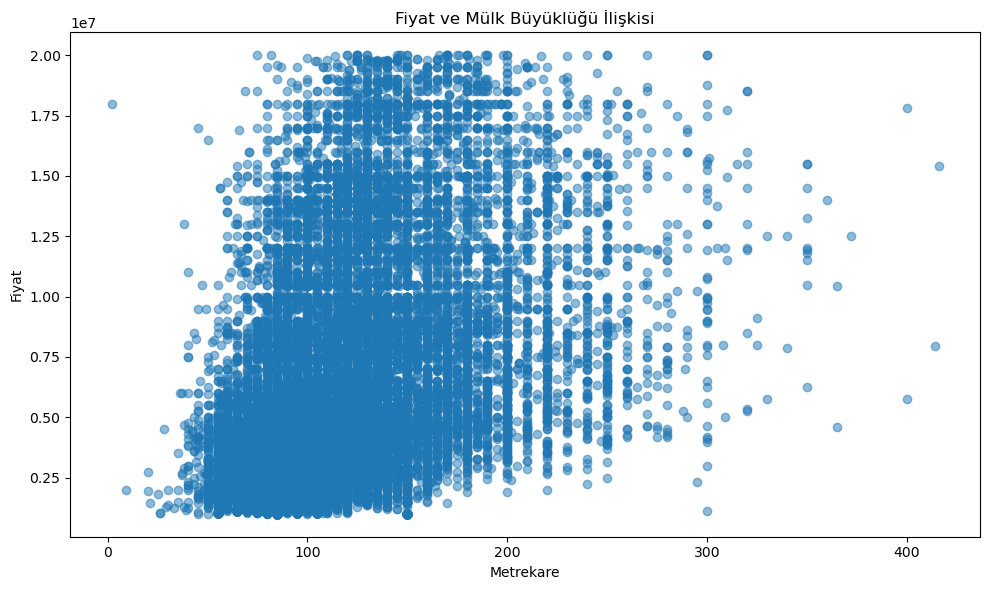

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df_clean = pd.concat([X_clean, y_clean], axis=1)
# DataFrame yüklü olduğunu varsayıyoruz: 'df'
def veri_kesif_analizi(df_clean):
    
    # İlçe Bazında Fiyat Dağılımı
    plt.figure(figsize=(15, 6))
    df_clean.boxplot(column='Fiyat', by='Ilce_encoded', rot=90)
    plt.title('İlçe Bazında Fiyat Dağılımı')
    plt.suptitle('')  # Otomatik başlığı kaldırır
    plt.ylabel('Fiyat')
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(12, 6))
    
    # 1. Grafik: Mülk Büyüklüğü Dağılımı
    plt.subplot(1, 2, 1)
    df_clean['Metre Kare'].hist(bins=30)
    plt.title('Mülk Büyüklüğü Dağılımı')
    plt.xlabel('Metrekare')
    
    # 2. Grafik: Mülk Büyüklüğü Kutu Grafiği
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df_clean['Metre Kare'])
    plt.title('Mülk Büyüklüğü Kutu Grafiği')
    
    plt.tight_layout()
    plt.show()
    
    # Yeni bir figure açarak ikinci grup grafikleri yerleştiriyoruz
    plt.figure(figsize=(12, 6))
    
    # 3. Grafik: Oda Sayısı Kutu Grafiği
    plt.subplot(1, 2, 1)
    sns.boxplot(x=df_clean['Oda Sayısı'])
    plt.title('Oda Sayısı Kutu Grafiği')
    
    # 4. Grafik: Yaş Kutu Grafiği
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df_clean['Yaş'])
    plt.title('Bina Yaşı Kutu Grafiği')
    
    plt.tight_layout()
    plt.show()
    
    # Fiyat ve Metrekare İlişkisi
    plt.figure(figsize=(10, 6))
    plt.scatter(df_clean['Metre Kare'], df_clean['Fiyat'], alpha=0.5)
    plt.title('Fiyat ve Mülk Büyüklüğü İlişkisi')
    plt.xlabel('Metrekare')
    plt.ylabel('Fiyat')
    plt.tight_layout()
    plt.show()
    

# Fonksiyonu Çağır
veri_kesif_analizi(df_clean)

# 5- Local Outlier Factor (LOF)

Her veri noktasının komşularına göre yoğunluğunu ölçer. Daha az yoğun bölgelerde bulunan noktalar aykırı değer olarak işaretlenir.

In [17]:
from sklearn.neighbors import LocalOutlierFactor

X = df_encoded[['Metre Kare', 'Oda Sayısı', 'Yaş', 'Bulunduğu Kat', 'Ilce_encoded', 'Mahalle_encoded']]
y = df_encoded['Fiyat']
# Local Outlier Factor (LOF) yöntemiyle aykırı değerleri tespit etme
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
outlier_pred = lof.fit_predict(X)
mask = outlier_pred != -1  # Aykırı olmayanları seç
X_clean = X[mask]
y_clean = y[mask]

# Veriyi eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)

# Modeli eğitme
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Modelin performansını değerlendirme
y_pred = rf_model.predict(X_test)
r2 = r2_score(y_test, y_pred)

print(f'R^2 Skoru: {r2:.4f}')
print(f'Veri sayısı: {len(X_clean)}')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


R^2 Skoru: 0.8508
Veri sayısı: 27190


<Figure size 1500x600 with 0 Axes>

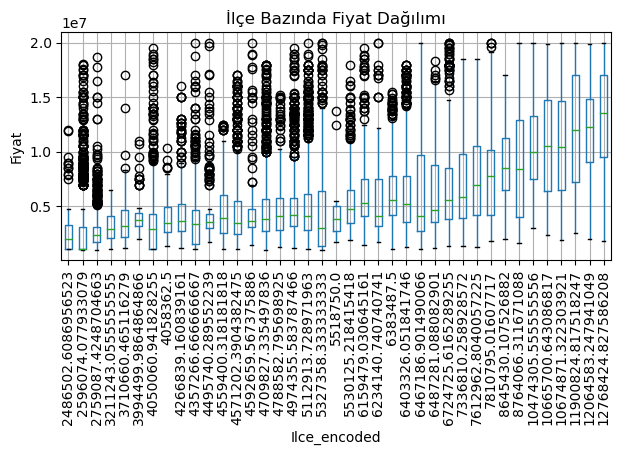

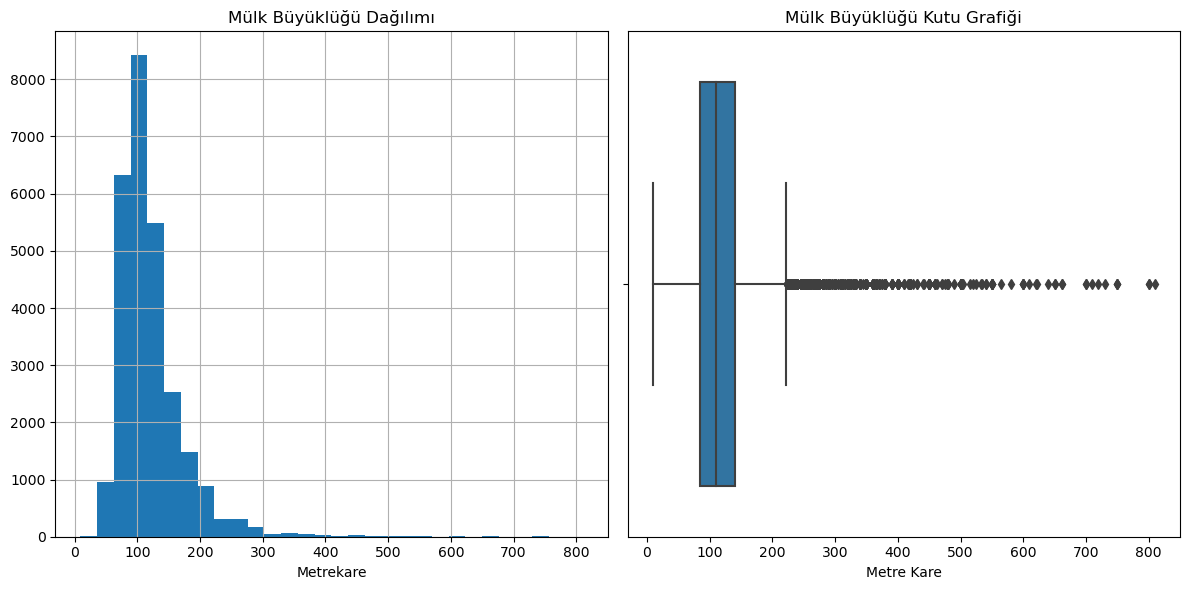

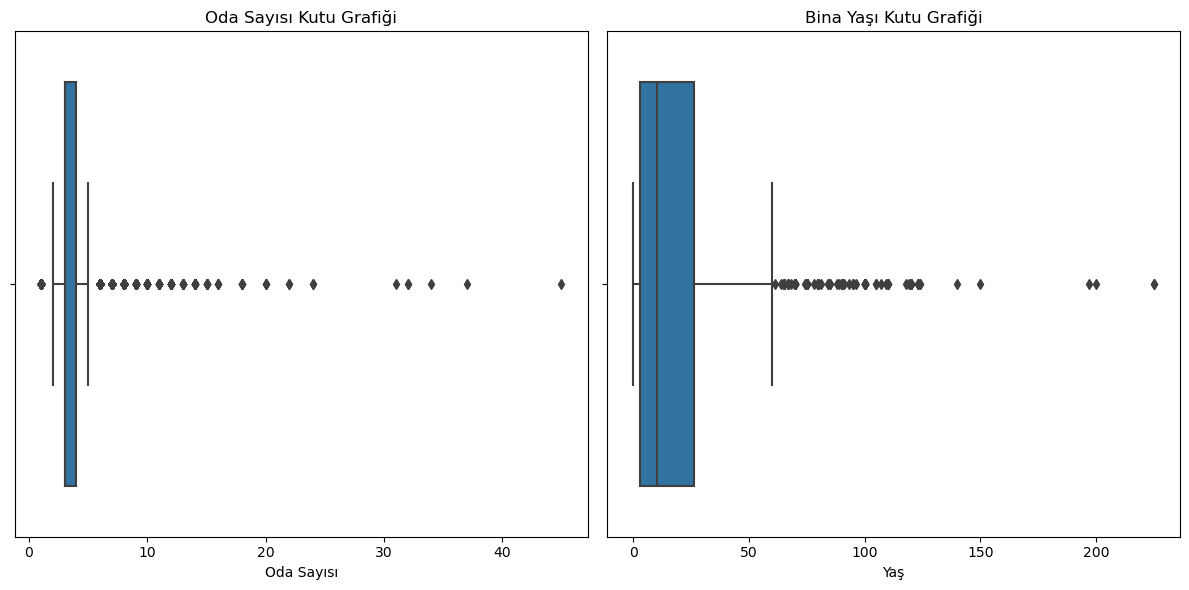

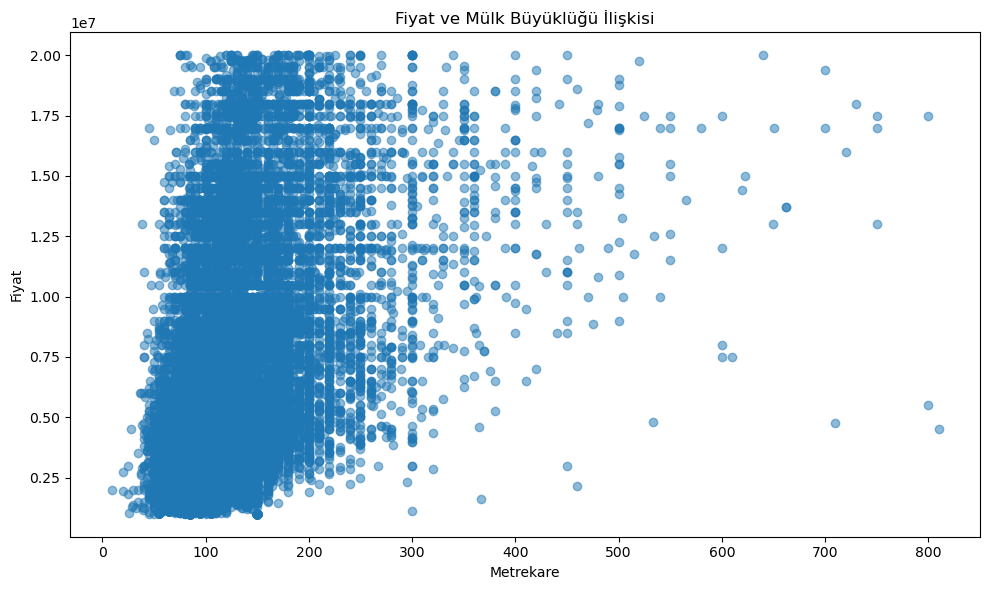

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df_clean = pd.concat([X_clean, y_clean], axis=1)
# DataFrame yüklü olduğunu varsayıyoruz: 'df'
def veri_kesif_analizi(df_clean):
    
    # İlçe Bazında Fiyat Dağılımı
    plt.figure(figsize=(15, 6))
    df_clean.boxplot(column='Fiyat', by='Ilce_encoded', rot=90)
    plt.title('İlçe Bazında Fiyat Dağılımı')
    plt.suptitle('')  # Otomatik başlığı kaldırır
    plt.ylabel('Fiyat')
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(12, 6))
    
    # 1. Grafik: Mülk Büyüklüğü Dağılımı
    plt.subplot(1, 2, 1)
    df_clean['Metre Kare'].hist(bins=30)
    plt.title('Mülk Büyüklüğü Dağılımı')
    plt.xlabel('Metrekare')
    
    # 2. Grafik: Mülk Büyüklüğü Kutu Grafiği
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df_clean['Metre Kare'])
    plt.title('Mülk Büyüklüğü Kutu Grafiği')
    
    plt.tight_layout()
    plt.show()
    
    # Yeni bir figure açarak ikinci grup grafikleri yerleştiriyoruz
    plt.figure(figsize=(12, 6))
    
    # 3. Grafik: Oda Sayısı Kutu Grafiği
    plt.subplot(1, 2, 1)
    sns.boxplot(x=df_clean['Oda Sayısı'])
    plt.title('Oda Sayısı Kutu Grafiği')
    
    # 4. Grafik: Yaş Kutu Grafiği
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df_clean['Yaş'])
    plt.title('Bina Yaşı Kutu Grafiği')
    
    plt.tight_layout()
    plt.show()
    
    # Fiyat ve Metrekare İlişkisi
    plt.figure(figsize=(10, 6))
    plt.scatter(df_clean['Metre Kare'], df_clean['Fiyat'], alpha=0.5)
    plt.title('Fiyat ve Mülk Büyüklüğü İlişkisi')
    plt.xlabel('Metrekare')
    plt.ylabel('Fiyat')
    plt.tight_layout()
    plt.show()
    

# Fonksiyonu Çağır
veri_kesif_analizi(df_clean)

# 6- DBSCAN (Density-Based Spatial Clustering)

Yoğunluk bazlı kümeleme yöntemidir. Küme yoğunluğuna uymayan noktalar aykırı olarak belirlenir.

In [19]:
from sklearn.cluster import DBSCAN

# Özellikler ve hedef değişkeni belirleme
X = df_encoded[['Metre Kare', 'Oda Sayısı', 'Yaş', 'Bulunduğu Kat', 'Ilce_encoded', 'Mahalle_encoded']]
y = df_encoded['Fiyat']

# DBSCAN yöntemiyle aykırı değerleri tespit etme
dbscan = DBSCAN(eps=13, min_samples=5)
labels = dbscan.fit_predict(X)
mask = labels != -1  # Aykırı olmayanları seç
X_clean = X[mask]
y_clean = y[mask]

# Veriyi eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)

# Modeli eğitme
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Modelin performansını değerlendirme
y_pred = rf_model.predict(X_test)
r2 = r2_score(y_test, y_pred)

print(f'R^2 Skoru: {r2:.4f}')
print(f'Veri sayısı: {len(X_clean)}')

R^2 Skoru: 0.8835
Veri sayısı: 22075


# 7- Hibrid Yöntem - (LOF + Manuel Veri Temizleme)

In [20]:
df_encoded.describe()

,Fiyat,Metre Kare,Oda Sayısı,Yaş,Bulunduğu Kat,Ilce_encoded,Mahalle_encoded
count,2.862200e+04,28622.000000,28622.000000,28622.000000,28622.000000,2.862200e+04,2.862200e+04
mean,6.150015e+06,120.517155,3.547935,14.792817,3.070016,6.150015e+06,6.150015e+06
std,4.625959e+06,55.072124,1.349637,14.770576,3.553854,2.967038e+06,3.442094e+06
min,1.000000e+06,2.000000,1.000000,0.000000,-3.000000,2.486503e+06,1.117637e+06
25%,2.775000e+06,85.000000,3.000000,3.000000,0.000000,4.266839e+06,3.805765e+06
50%,4.449000e+06,110.000000,3.000000,10.000000,2.000000,5.112914e+06,4.930245e+06
75%,8.500000e+06,140.000000,4.000000,26.000000,4.000000,7.612963e+06,8.137280e+06
max,2.000000e+07,810.000000,45.000000,225.000000,21.000000,1.276842e+07,1.899167e+07


In [21]:
df_encoded

,Fiyat,İlce,Mahalle,Metre Kare,Oda Sayısı,Yaş,Bulunduğu Kat,Ilce_encoded,Mahalle_encoded
0,5000000,Adalar,Burgazada Mah,55,2.0,24.0,0.0,1.047431e+07,1.064654e+07
1,7500000,Adalar,Nizam Mah,65,2.0,31.0,0.0,1.047431e+07,1.104514e+07
2,4750000,Adalar,Nizam Mah,60,2.0,34.0,0.0,1.047431e+07,1.104514e+07
3,7000000,Adalar,MadeMah,75,2.0,35.0,0.0,1.047431e+07,9.944185e+06
4,4200000,Adalar,Nizam Mah,51,2.0,38.0,0.0,1.047431e+07,1.104514e+07
...,...,...,...,...,...,...,...,...,...
28617,4150000,Zeytinburnu,VeliefendMah.,150,6.0,29.0,1.0,4.050061e+06,1.965306e+06
28618,4500000,Zeytinburnu,VeliefendMah.,170,6.0,30.0,1.0,4.050061e+06,1.965306e+06
28619,17000000,Zeytinburnu,Gökalp Mah.,350,12.0,16.0,0.0,4.050061e+06,4.250833e+06
28620,19000000,Zeytinburnu,Beştelsiz Mah.,500,12.0,28.0,0.0,4.050061e+06,5.503889e+06


In [22]:
df_clean = pd.concat([X_clean, y_clean], axis=1)

In [23]:
df_new=df_encoded.copy()

In [24]:
df_new=df_encoded[df_encoded["Oda Sayısı"]<8]
df_new=df_encoded[df_encoded["Yaş"]<57]
df_new = df_encoded[(df_encoded["Metre Kare"] < 270) & (df_encoded["Metre Kare"] > 40)]

In [25]:
X_clean = df_new[['Metre Kare', 'Oda Sayısı', 'Yaş', 'Bulunduğu Kat', 'Ilce_encoded', 'Mahalle_encoded']]
y_clean = df_new['Fiyat']

# Veriyi eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)

# Modeli eğitme
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Modelin performansını değerlendirme
y_pred = rf_model.predict(X_test)
r2 = r2_score(y_test, y_pred)

print(f'R^2 Skoru: {r2:.4f}')
print(f'Veri sayısı: {len(X_clean)}')

R^2 Skoru: 0.8334
Veri sayısı: 27961


In [26]:
df_clean = pd.concat([X_clean, y_clean], axis=1)
# İlçe bazında Fiyat, Metre Kare, Oda Sayısı ve Yaş değişkenleri için ortalama ve standart sapma hesaplama
stats = df_clean.groupby('Ilce_encoded').agg(
    Fiyat_mean=('Fiyat', 'mean'), Fiyat_std=('Fiyat', 'std'),
    MetreKare_mean=('Metre Kare', 'mean'), MetreKare_std=('Metre Kare', 'std'),
    OdaSayisi_mean=('Oda Sayısı', 'mean'), OdaSayisi_std=('Oda Sayısı', 'std'),
    Yas_mean=('Yaş', 'mean'), Yas_std=('Yaş', 'std')
).reset_index()

# Aykırı değer eşiğini hesaplama ve kontrol etme
def is_outlier(row, stats):
    ilce_stats = stats[stats['Ilce_encoded'] == row['Ilce_encoded']].iloc[0]
    
    # Eşik değerler
    fiyat_threshold = ilce_stats['Fiyat_mean'] + 2 * ilce_stats['Fiyat_std'] + 1
    metrekare_threshold = ilce_stats['MetreKare_mean'] + 2 * ilce_stats['MetreKare_std'] + 1
    odasayisi_threshold = ilce_stats['OdaSayisi_mean'] + 2 * ilce_stats['OdaSayisi_std'] + 1
    yas_threshold = ilce_stats['Yas_mean'] + 2 * ilce_stats['Yas_std'] + 1

    # Aykırı değer kontrolü
    if (row['Fiyat'] > fiyat_threshold or 
        row['Metre Kare'] > metrekare_threshold or 
        row['Oda Sayısı'] > odasayisi_threshold or 
        row['Yaş'] > yas_threshold):
        return True
    return False

# Aykırı değerleri filtreleme
filtered_data = df_clean[~df_clean.apply(lambda row: is_outlier(row, stats), axis=1)]

# Sonuç
print(f"Orijinal veri boyutu: {len(df_clean)}")
print(f"Temizlenmiş veri boyutu: {len(filtered_data)}")

Orijinal veri boyutu: 27961
Temizlenmiş veri boyutu: 24973


In [27]:
filtered_data

,Metre Kare,Oda Sayısı,Yaş,Bulunduğu Kat,Ilce_encoded,Mahalle_encoded,Fiyat
0,55,2.0,24.0,0.0,1.047431e+07,1.064654e+07,5000000
1,65,2.0,31.0,0.0,1.047431e+07,1.104514e+07,7500000
2,60,2.0,34.0,0.0,1.047431e+07,1.104514e+07,4750000
3,75,2.0,35.0,0.0,1.047431e+07,9.944185e+06,7000000
4,51,2.0,38.0,0.0,1.047431e+07,1.104514e+07,4200000
...,...,...,...,...,...,...,...
28604,150,5.0,30.0,0.0,4.050061e+06,1.965306e+06,3000000
28607,125,5.0,31.0,0.0,4.050061e+06,4.250833e+06,2650000
28608,150,5.0,31.0,1.0,4.050061e+06,3.729308e+06,4449000
28614,150,6.0,25.0,1.0,4.050061e+06,3.708659e+06,4200000


In [28]:
from sklearn.neighbors import LocalOutlierFactor

X = filtered_data[['Metre Kare', 'Oda Sayısı', 'Yaş', 'Bulunduğu Kat', 'Ilce_encoded', 'Mahalle_encoded']]
y = filtered_data['Fiyat']
# Local Outlier Factor (LOF) yöntemiyle aykırı değerleri tespit etme
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
outlier_pred = lof.fit_predict(X)
mask = outlier_pred != -1  # Aykırı olmayanları seç
X_clean = X[mask]
y_clean = y[mask]

# Veriyi eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)

# Modeli eğitme
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Modelin performansını değerlendirme
y_pred = rf_model.predict(X_test)
r2 = r2_score(y_test, y_pred)

print(f'R^2 Skoru: {r2:.4f}')
print(f'Veri sayısı: {len(X_clean)}')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


R^2 Skoru: 0.8875
Veri sayısı: 23724


In [29]:
df_clean = pd.concat([X_clean, y_clean], axis=1)

<Figure size 1500x600 with 0 Axes>

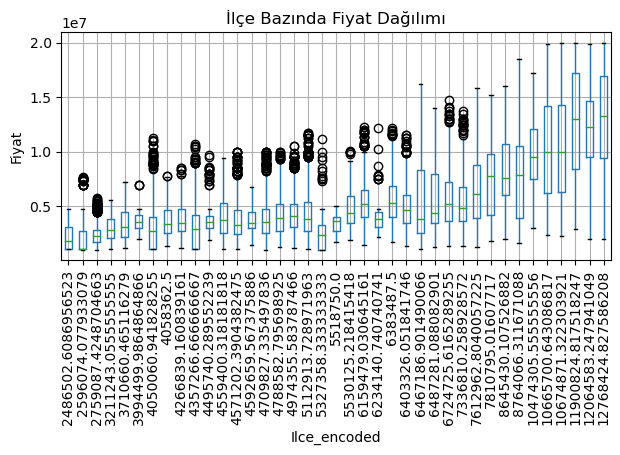

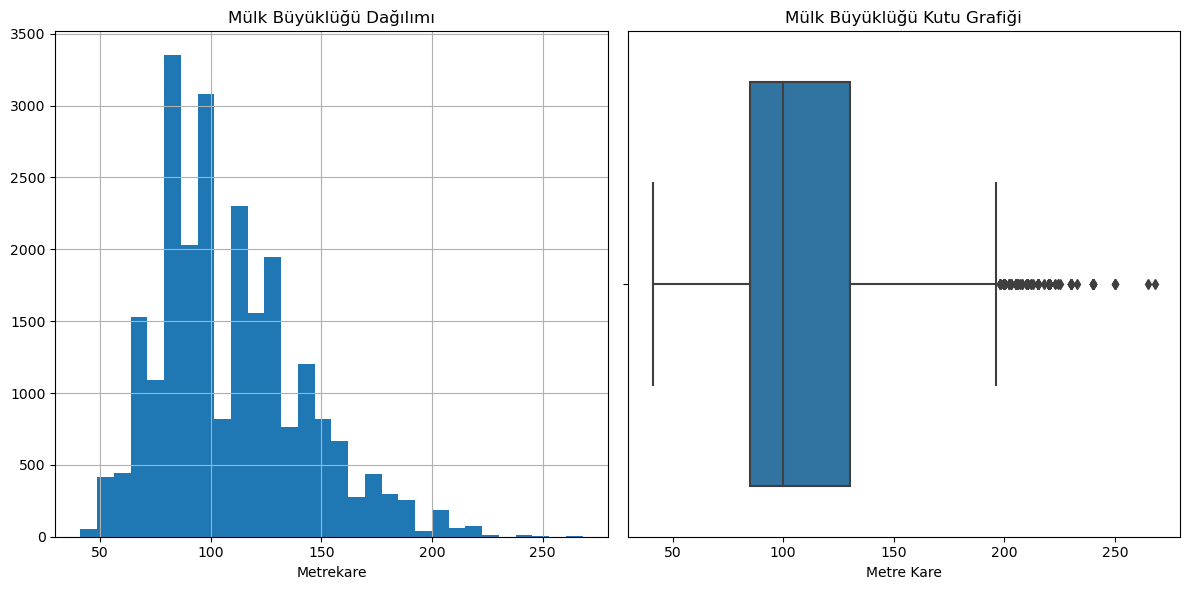

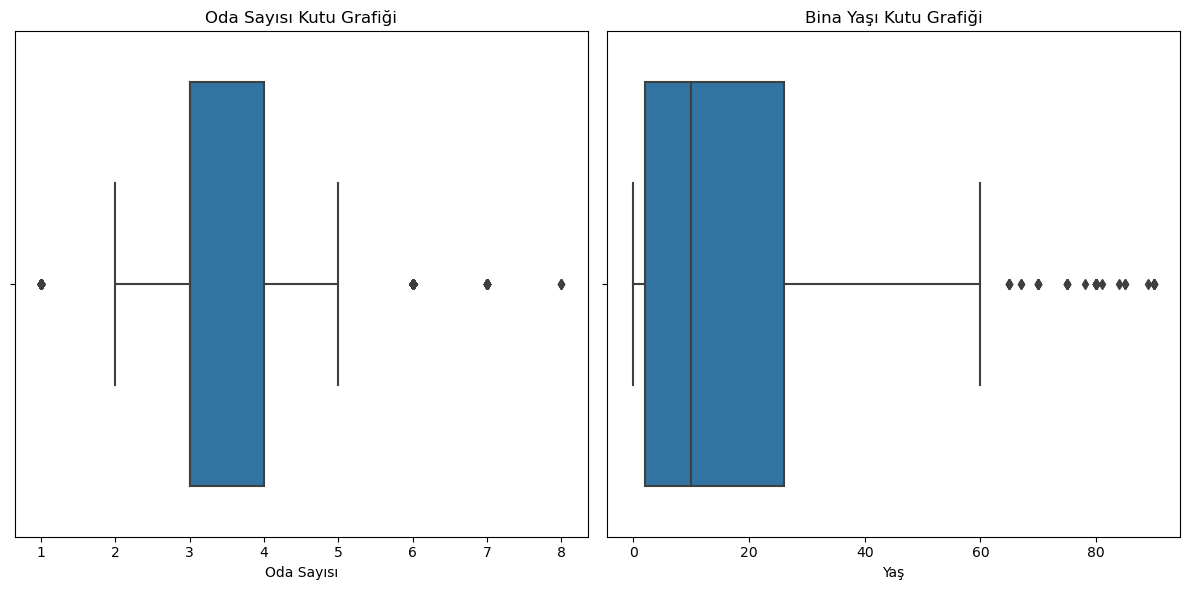

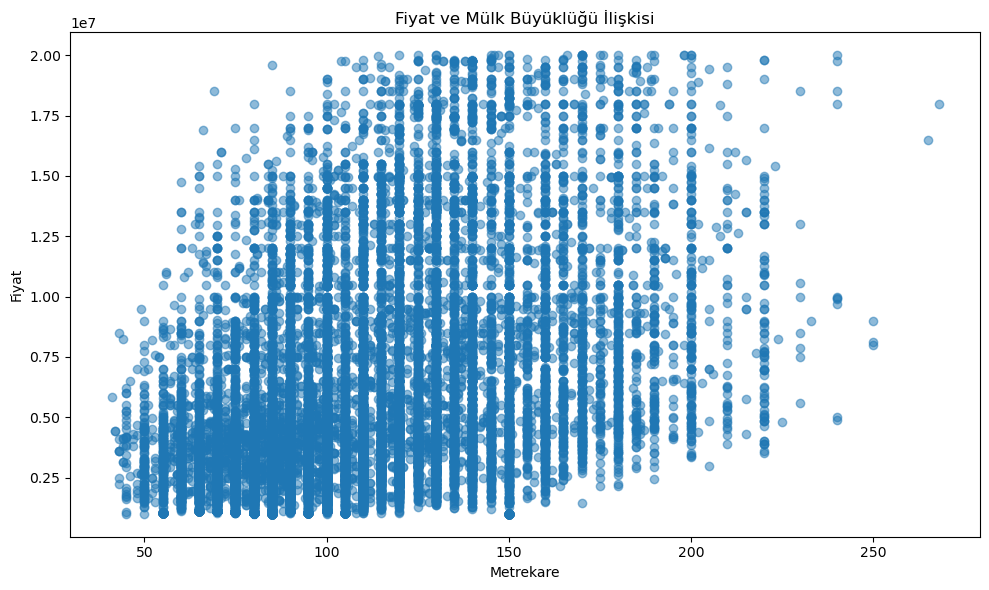

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df_clean = pd.concat([X_clean, y_clean], axis=1)
# DataFrame yüklü olduğunu varsayıyoruz: 'df'
def veri_kesif_analizi(df_clean):
    
    # İlçe Bazında Fiyat Dağılımı
    plt.figure(figsize=(15, 6))
    df_clean.boxplot(column='Fiyat', by='Ilce_encoded', rot=90)
    plt.title('İlçe Bazında Fiyat Dağılımı')
    plt.suptitle('')  # Otomatik başlığı kaldırır
    plt.ylabel('Fiyat')
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(12, 6))
    
    # 1. Grafik: Mülk Büyüklüğü Dağılımı
    plt.subplot(1, 2, 1)
    df_clean['Metre Kare'].hist(bins=30)
    plt.title('Mülk Büyüklüğü Dağılımı')
    plt.xlabel('Metrekare')
    
    # 2. Grafik: Mülk Büyüklüğü Kutu Grafiği
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df_clean['Metre Kare'])
    plt.title('Mülk Büyüklüğü Kutu Grafiği')
    
    plt.tight_layout()
    plt.show()
    
    # Yeni bir figure açarak ikinci grup grafikleri yerleştiriyoruz
    plt.figure(figsize=(12, 6))
    
    # 3. Grafik: Oda Sayısı Kutu Grafiği
    plt.subplot(1, 2, 1)
    sns.boxplot(x=df_clean['Oda Sayısı'])
    plt.title('Oda Sayısı Kutu Grafiği')
    
    # 4. Grafik: Yaş Kutu Grafiği
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df_clean['Yaş'])
    plt.title('Bina Yaşı Kutu Grafiği')
    
    plt.tight_layout()
    plt.show()
    
    # Fiyat ve Metrekare İlişkisi
    plt.figure(figsize=(10, 6))
    plt.scatter(df_clean['Metre Kare'], df_clean['Fiyat'], alpha=0.5)
    plt.title('Fiyat ve Mülk Büyüklüğü İlişkisi')
    plt.xlabel('Metrekare')
    plt.ylabel('Fiyat')
    plt.tight_layout()
    plt.show()
    

# Fonksiyonu Çağır
veri_kesif_analizi(df_clean)

# 8- Hibrid Yöntem - (IQR + Manuel Veri Temizleme)

In [31]:
# Özellikler ve hedef değişkeni belirleme
X = filtered_data[['Metre Kare', 'Oda Sayısı', 'Yaş', 'Bulunduğu Kat', 'Ilce_encoded', 'Mahalle_encoded']]
y = filtered_data['Fiyat']

# IQR yöntemiyle aykırı değerleri temizleme
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 2 * IQR
upper_bound = Q3 + 2 * IQR
mask = ~((X < lower_bound) | (X > upper_bound)).any(axis=1)
X_clean = X[mask]
y_clean = y[mask]

# Veriyi eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)

# Modeli eğitme
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Modelin performansını değerlendirme
y_pred = rf_model.predict(X_test)
r2 = r2_score(y_test, y_pred)

print(f'R^2 Skoru: {r2:.4f}')
print(f'Veri sayısı: {len(X_clean)}')

R^2 Skoru: 0.8932
Veri sayısı: 24129


<Figure size 1500x600 with 0 Axes>

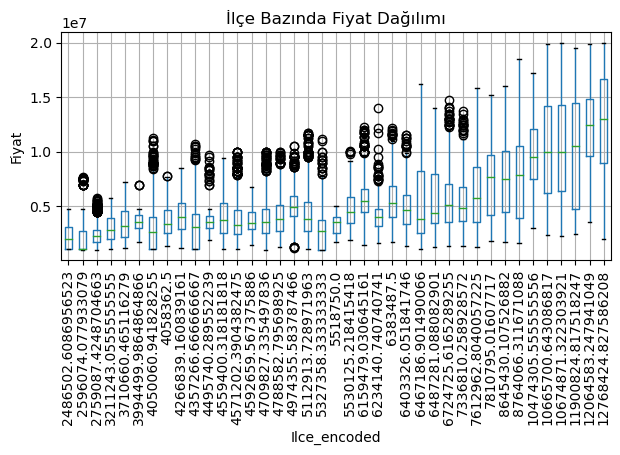

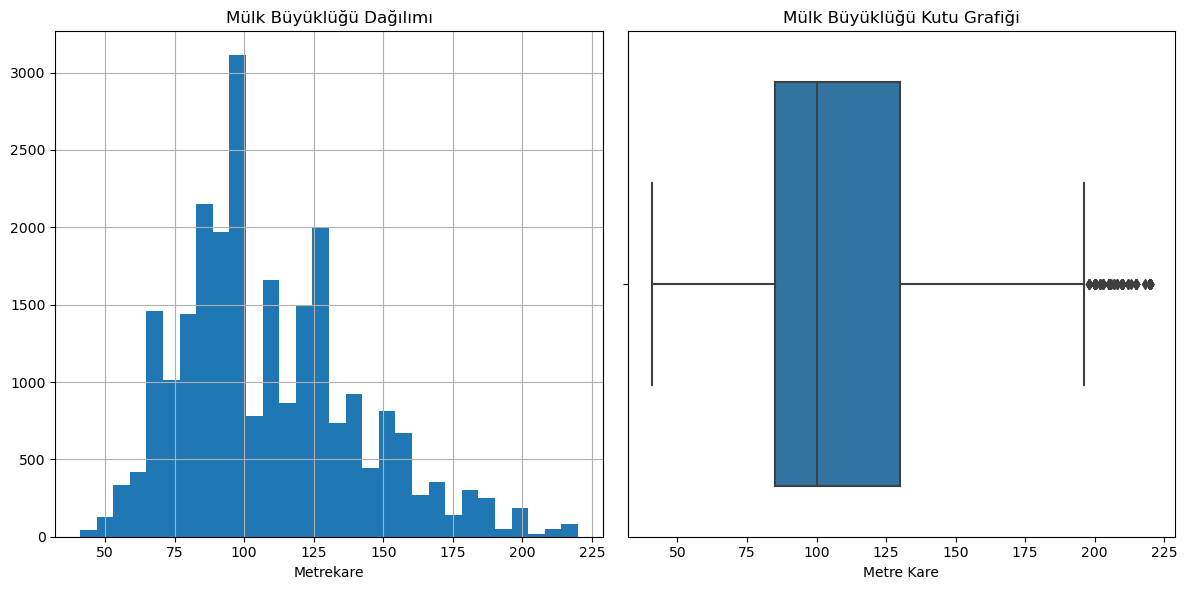

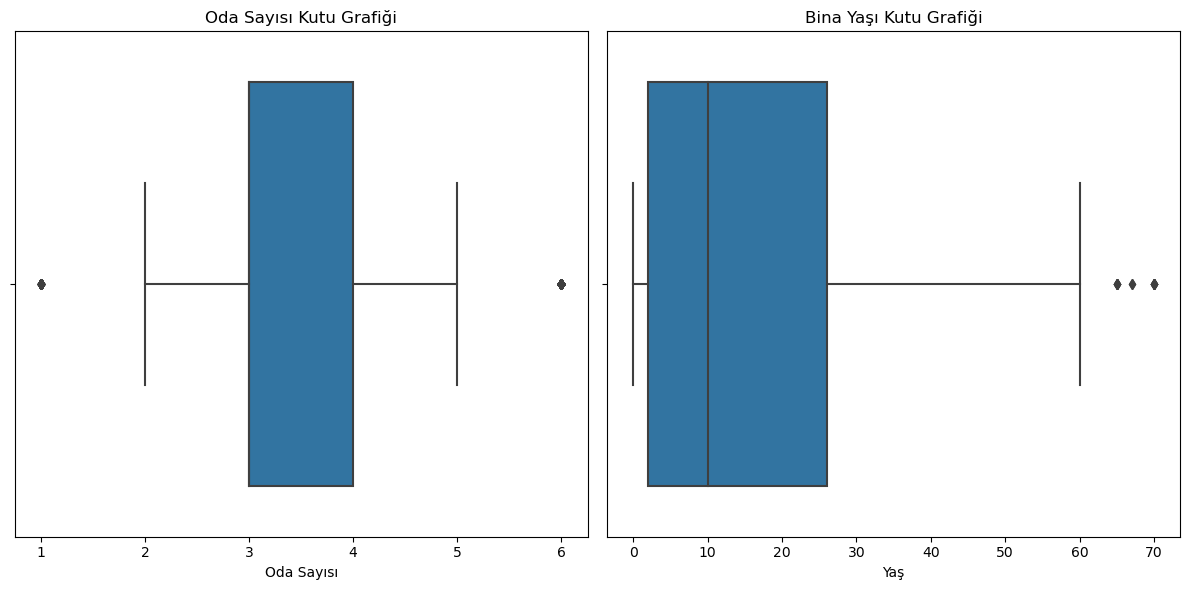

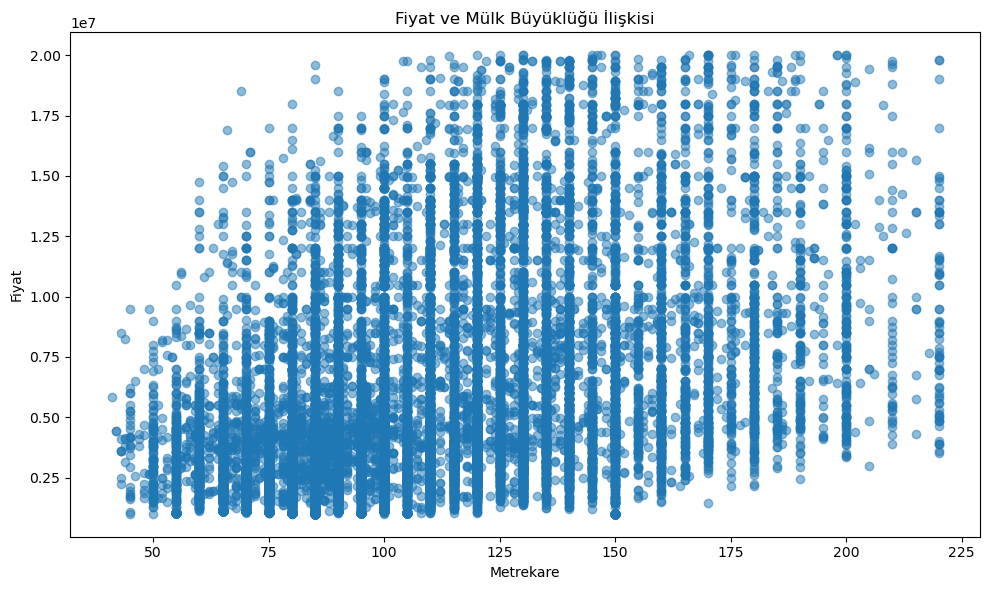

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df_clean = pd.concat([X_clean, y_clean], axis=1)
# DataFrame yüklü olduğunu varsayıyoruz: 'df'
def veri_kesif_analizi(df_clean):
    
    # İlçe Bazında Fiyat Dağılımı
    plt.figure(figsize=(15, 6))
    df_clean.boxplot(column='Fiyat', by='Ilce_encoded', rot=90)
    plt.title('İlçe Bazında Fiyat Dağılımı')
    plt.suptitle('')  # Otomatik başlığı kaldırır
    plt.ylabel('Fiyat')
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(12, 6))
    
    # 1. Grafik: Mülk Büyüklüğü Dağılımı
    plt.subplot(1, 2, 1)
    df_clean['Metre Kare'].hist(bins=30)
    plt.title('Mülk Büyüklüğü Dağılımı')
    plt.xlabel('Metrekare')
    
    # 2. Grafik: Mülk Büyüklüğü Kutu Grafiği
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df_clean['Metre Kare'])
    plt.title('Mülk Büyüklüğü Kutu Grafiği')
    
    plt.tight_layout()
    plt.show()
    
    # Yeni bir figure açarak ikinci grup grafikleri yerleştiriyoruz
    plt.figure(figsize=(12, 6))
    
    # 3. Grafik: Oda Sayısı Kutu Grafiği
    plt.subplot(1, 2, 1)
    sns.boxplot(x=df_clean['Oda Sayısı'])
    plt.title('Oda Sayısı Kutu Grafiği')
    
    # 4. Grafik: Yaş Kutu Grafiği
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df_clean['Yaş'])
    plt.title('Bina Yaşı Kutu Grafiği')
    
    plt.tight_layout()
    plt.show()
    
    # Fiyat ve Metrekare İlişkisi
    plt.figure(figsize=(10, 6))
    plt.scatter(df_clean['Metre Kare'], df_clean['Fiyat'], alpha=0.5)
    plt.title('Fiyat ve Mülk Büyüklüğü İlişkisi')
    plt.xlabel('Metrekare')
    plt.ylabel('Fiyat')
    plt.tight_layout()
    plt.show()
    

# Fonksiyonu Çağır
veri_kesif_analizi(df_clean)